# Data Imputation and Outlier Removal Tutorial

In this notebook, we will learn how to handle missing data through imputation and how to remove outliers from our dataset.

## Libraries

- **Pandas**: A software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.
- **Numpy**: A library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- **Scikit-learn (sklearn)**: A machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.


In [17]:
# Importing required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from scipy import stats

## Data Imputation

Data imputation is the process of replacing missing data with substituted values. There are many strategies for this, such as using the mean, median, or mode of the column, using a constant, or using the most frequent value.

In this tutorial, we will use the `SimpleImputer` class from `sklearn.impute` to replace missing values with the mean of the column. Let's first create a dummy DataFrame with some missing values.


In [3]:
# Generate a dataset with missing data and outliers
np.random.seed(0)
data = pd.DataFrame(np.random.normal(size=(100, 4)), columns=['A', 'B', 'C', 'D'])
data.iloc[10:20, 0] = np.nan  # Set missing values in column 'A'
data.iloc[30:35, 1] = np.nan  # Set missing values in column 'B'
data.iloc[60:65, 2] = np.nan  # Set missing values in column 'C'
data.iloc[80:85, 3] = np.nan  # Set missing values in column 'D'
data.iloc[95, 0] = 10  # Add an outlier to column 'A'
data.iloc[75, 2] = -8   # Add an outlier to column 'C'
data.head()

,A,B,C,D
0,1.764052,0.400157,0.978738,2.240893
1,1.867558,-0.977278,0.950088,-0.151357
2,-0.103219,0.410599,0.144044,1.454274
3,0.761038,0.121675,0.443863,0.333674
4,1.494079,-0.205158,0.313068,-0.854096


In [9]:
data.info()
print(data.isna().sum())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       90 non-null     float64
 1   B       95 non-null     float64
 2   C       95 non-null     float64
 3   D       95 non-null     float64
dtypes: float64(4)
memory usage: 3.2 KB
A    10
B     5
C     5
D     5
dtype: int64


,A,B,C,D
count,90.000000,95.000000,95.000000,95.000000
mean,0.209072,-0.106957,-0.266345,0.123358
std,1.509613,0.996174,1.197347,0.944536
min,-2.552990,-2.069985,-8.000000,-2.772593
25%,-0.724099,-0.771835,-0.728097,-0.459424
50%,0.024565,-0.212740,-0.268003,0.156704
75%,0.827805,0.445163,0.397527,0.700661
max,10.000000,1.943621,2.259309,2.240893


Now, let's use the `SimpleImputer` class to replace the missing values with the mean of the respective column.


In [10]:
# Creating the SimpleImputer object
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Performing the imputation
df_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
print(df_imputed.isna().sum())
df_imputed.describe()

# note that replacing the missing values w/ the mean dit not change the mean (although it did change the percentiles and median)

A    0
B    0
C    0
D    0
dtype: int64


,A,B,C,D
count,100.000000,100.000000,100.000000,100.000000
mean,0.209072,-0.106957,-0.266345,0.123358
std,1.431341,0.970692,1.166720,0.920375
min,-2.552990,-2.069985,-8.000000,-2.772593
25%,-0.697101,-0.699832,-0.688891,-0.416992
50%,0.209072,-0.157292,-0.266345,0.126171
75%,0.772156,0.421885,0.366276,0.684883
max,10.000000,1.943621,2.259309,2.240893


## Outlier Removal

Outliers are data points that are significantly different from other observations. They can occur due to variability in the data or errors. Outliers can significantly affect the results of your data analysis and statistical modeling.

There are many ways to identify and remove outliers, such as the Z-score method, the IQR method, etc. In this tutorial, we will use the Z-score method to remove outliers. The Z-score is a measure of how many standard deviations an element is from the mean. A Z-score greater than 3 or less than -3 is generally considered to be an outlier.

Let's do my fave! The violin plot. We'll also do histograms

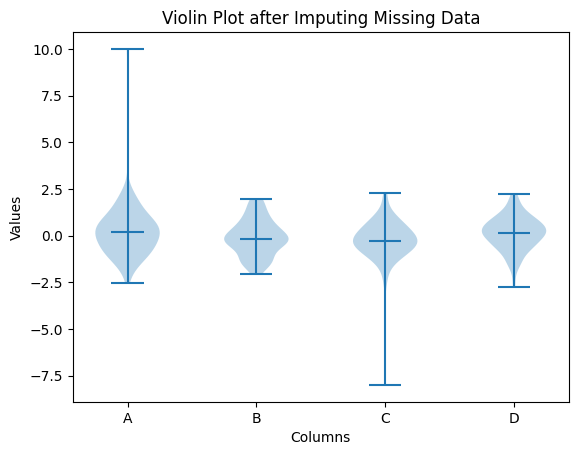

In [13]:
# Generate violin plot
plt.figure()
plt.violinplot(df_imputed.values, showmedians=True)
plt.title('Violin Plot after Imputing Missing Data')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(np.arange(1, len(df_imputed.columns) + 1), df_imputed.columns)
plt.show()

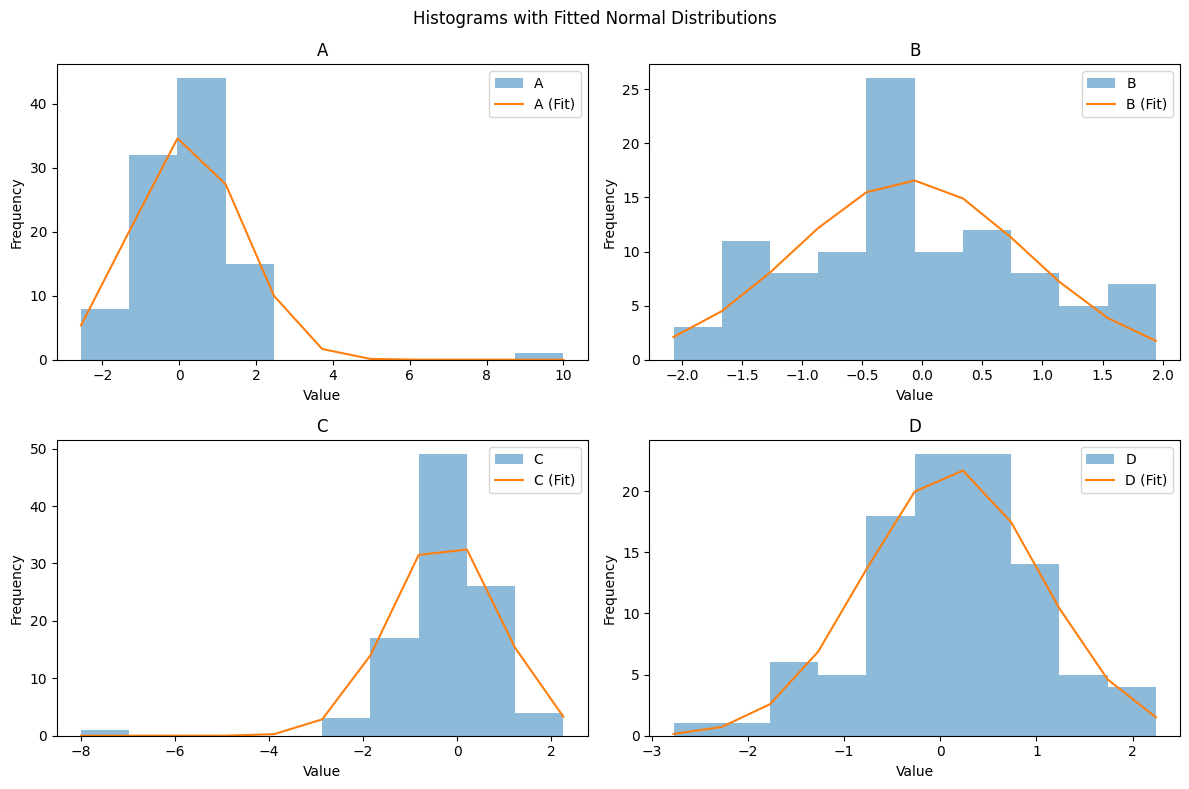

In [20]:
# Generate histograms with fitted normal distributions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histograms with Fitted Normal Distributions')

for i, column in enumerate(df_imputed.columns):
    ax = axes[i // 2, i % 2]

    # Plot histogram
    n, bins, _ = ax.hist(df_imputed[column], bins=10, alpha=0.5, label=column)

    # Fit normal distribution to the data
    mu, sigma = stats.norm.fit(df_imputed[column])

    # Calculate the probability density function (PDF)
    pdf = stats.norm.pdf(bins, mu, sigma) * np.diff(bins)[0] * len(df_imputed[column])

    # Plot fitted normal distribution
    ax.plot(bins, pdf, label=f'{column} (Fit)')

    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{column}')

plt.tight_layout()
plt.show()

Given the way the data was generated, these are still normal, but you get the point

Now, let's use the Z-score method to identify and remove the outliers.

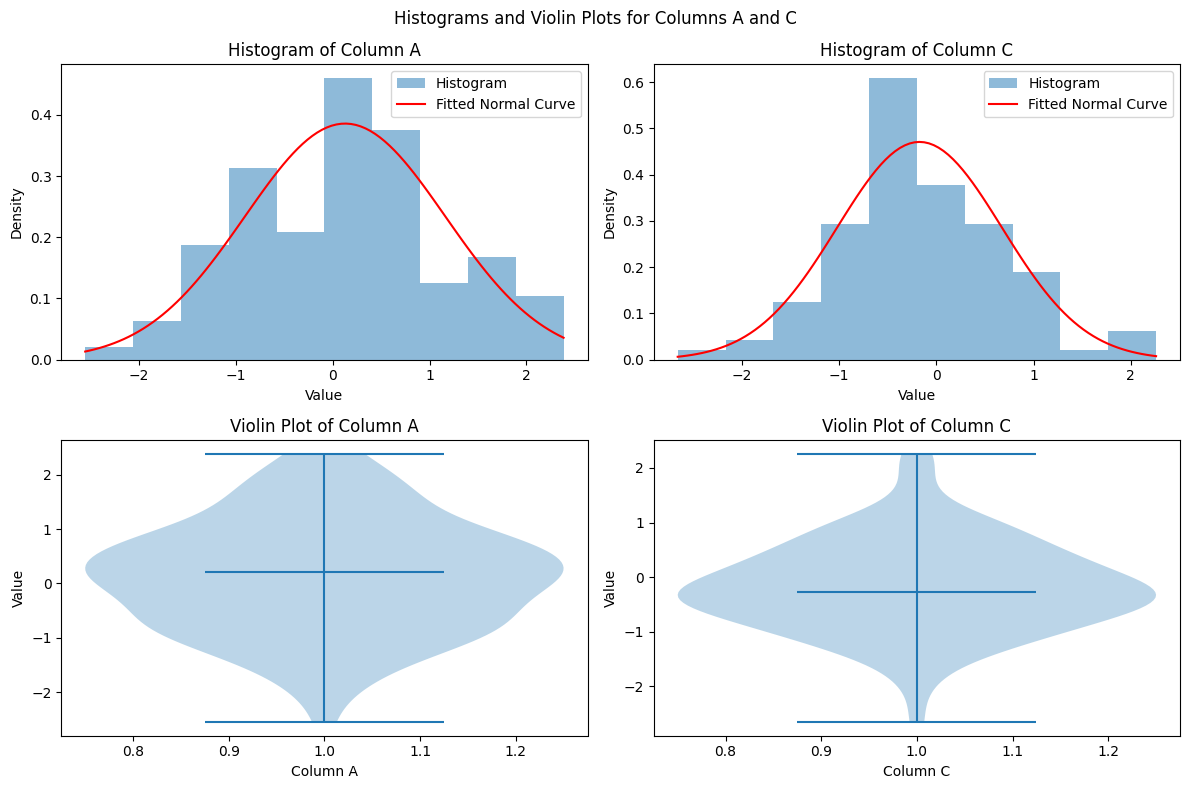

In [24]:
# Remove outliers using z-scores
z_scores = np.abs(stats.zscore(df_imputed))
df_imputed = df_imputed[(z_scores < 3).all(axis=1)]

# Create subplots for histograms and violin plots of columns 'A' and 'C'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histograms and Violin Plots for Columns A and C')

# Histograms for column 'A'
axes[0, 0].hist(df_imputed['A'], bins=10, alpha=0.5, density=True, label='Histogram')
mu_A, sigma_A = stats.norm.fit(df_imputed['A'])
x_A = np.linspace(df_imputed['A'].min(), df_imputed['A'].max(), 100)
y_A = stats.norm.pdf(x_A, mu_A, sigma_A)
axes[0, 0].plot(x_A, y_A, 'r', label='Fitted Normal Curve')
axes[0, 0].set_title('Histogram of Column A')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Histograms for column 'C'
axes[0, 1].hist(df_imputed['C'], bins=10, alpha=0.5, density=True, label='Histogram')
mu_C, sigma_C = stats.norm.fit(df_imputed['C'])
x_C = np.linspace(df_imputed['C'].min(), df_imputed['C'].max(), 100)
y_C = stats.norm.pdf(x_C, mu_C, sigma_C)
axes[0, 1].plot(x_C, y_C, 'r', label='Fitted Normal Curve')
axes[0, 1].set_title('Histogram of Column C')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Violin plots for column 'A'
axes[1, 0].violinplot(df_imputed['A'], showmedians=True)
axes[1, 0].set_title('Violin Plot of Column A')
axes[1, 0].set_xlabel('Column A')
axes[1, 0].set_ylabel('Value')

# Violin plots for column 'C'
axes[1, 1].violinplot(df_imputed['C'], showmedians=True)
axes[1, 1].set_title('Violin Plot of Column C')
axes[1, 1].set_xlabel('Column C')
axes[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()


Much better